# 補足

In [1]:
%matplotlib inline

import itertools

import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

`itertools` 標準ライブラリは便利なイテレータ関数をたくさん定義しています. ここではその内のいくつかを紹介します. 

### `itertools.count`

In [6]:
cnt = itertools.count()
while cnt < 10:
    

In [ ]:
cnt = itertools.count

In [2]:
dir(itertools)

['__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_grouper',
 '_tee',
 '_tee_dataobject',
 'accumulate',
 'chain',
 'combinations',
 'combinations_with_replacement',
 'compress',
 'count',
 'cycle',
 'dropwhile',
 'filterfalse',
 'groupby',
 'islice',
 'permutations',
 'product',
 'repeat',
 'starmap',
 'takewhile',
 'tee',
 'zip_longest']

In [24]:
x = [1, 2, 3]
x_ndarray = np.array(x)
x_ndarray

array([1, 2, 3])

In [25]:
x_asarray = np.asarray(x)
x_asarray

array([1, 2, 3])

In [26]:
x_array = np.asarray(x_ndarray)
print('id of x_array is {}'.format(id(x_array)))
print('id of x_ndarray is {}'.format(id(x_ndarray)))

id of x_array is 4442956864
id of x_ndarray is 4442956864


In [27]:
x_array_copy = np.array(x_ndarray)
print('id of x_array_copy is {}'.format(id(x_array_copy)))
print('id of x_ndarray is {}'.format(id(x_ndarray)))

id of x_array_copy is 4442956944
id of x_ndarray is 4442956864


If origin is zero:

\begin{align}
    x_{t+1} = Ax_t
\end{align}

If origin is $x^*$:

\begin{align}
    x_{t+1} - x^* = A(x_t - x^*) \Rightarrow x_{t+1} = A(x_t - x^*) + x^*
\end{align}

Time reversal:

\begin{align}
    A^{-1}(x_{t+1} - x^*) = x_t - x^* \Rightarrow x_t = A^{-1}(x_{t+1} - x^*) + x^*
\end{align}

In [28]:
class LinearSystem:
    """Linear/Affine system"""

    def __init__(self, A, origin=None):
        self.A = np.asarray(A)
        self.origin = np.zeros(A.shape[0]) if origin is None else np.asarray(origin)

    def forward(self, x):
        return np.dot(self.A, np.asarray(x) - self.origin) + self.origin

    def reverse(self, x):
        return la.solve(self.A, np.asarray(x) - self.origin) + self.origin

    def eig(self):
        """Eigen values and eigen vectors"""
        return la.eig(self.A)

In [29]:
class Ramsey:
    """One-sector Ramsey model"""

    def __init__(self, A, α, ρ):
        self.A, self.α, self.ρ = A, α, ρ

    def f(self, x):
        """Production function"""
        return self.A * x ** self.α

    def U(self, x):
        """Utility from consumption"""
        return np.log(x)

    def u(self, x, y):
        """Reduced form utility"""
        return self.U(self.f(x) - y)

    def is_feasible(self, x, y):
        """Checks feasibility"""
        return x >= 0 and y >= 0 and self.f(x) >= y

    def steady_state(self):
        """Steady state for the model"""
        A, α, ρ = self.A, self.α, self.ρ
        koo = (ρ * α * A) ** (1 / (1 - α))
        return np.array([koo, koo])

    def forward(self, x):
        """Forward evolution"""
        A, α, ρ = self.A, self.α, self.ρ
        return np.array([
            x[1],
            ((1 + ρ * α) * A * x[1] ** α -
             ρ * α * (A ** 2) * (x[1] ** (α - 1)) * (x[0] ** α))
        ])

    def reverse(self, x):
        """Backward evolution"""
        A, α, ρ = self.A, self.α, self.ρ
        return np.array([
            ((((1 + ρ * α) * A * x[0] ** α - x[1]) /
              (ρ * α * A ** 2 * x[0] ** (α - 1))) ** (1 / α)),
            x[0]
        ])

    def jacobian(self, x=None):
        """Returns jacobian matrix"""
        A, α, ρ = self.A, self.α, self.ρ

        def _jacobian(x):
            """Jacobian as a function of state"""
            return  np.array([
                [0, 1],
                [-ρ * ((α * A) ** 2) * ((x[0] * x[1]) ** (α - 1)),
                 (α * (1 + ρ * α) * A * x[0] ** (α - 1) -
                  ρ * α * (α-1) * (A ** 2) * (x[0]**α) * (x[1] ** (α-2)))]
            ])

        if x is None:
            return _jacobian(self.steady_state())
        return _jacobian(x)

In [30]:
def linearize(diffsys, ss):
    """Linearize differentiable system around a steady state"""
    return LinearSystem(diffsys.jacobian(ss), ss)

In [31]:
class Simulation:
    """Simulation of a dynamical system"""

    def __init__(self, system, x0=None, duration=np.Inf, 
                 inverse=False, domain=None):
        self.system = system
        self.x0 = x0
        self.duration = duration
        self.inverse = inverse
        if domain is not None:
            self.domain = domain
        else:
            self.domain = lambda x: True

    def __iter__(self):
        x = self.x0[:]
        tick = self.system.forward if not self.inverse else self.system.reverse
        t = itertools.count()
        while next(t) < self.duration and self.domain(x):
            yield x
            x = tick(x)
        del t

    def reset(self, x0=None, duration=None, inverse=None):
        """Reset simulation parameters"""

        if x0 is not None:
            self.x0 = x0[:]
        if duration is not None:
            self.duration = duration
        if inverse is not None:
            self.inverse = inverse
        return self

    def __repr__(self):
        text = "Simulation({},\n"
        text += "           x0={},\n"
        text += "           duration={})"
        return text.format(
            str(self.system),
            str(self.x0),
            str(self.duration)
        )

In [32]:
mat = np.random.random((2, 2))
mat

array([[ 0.02999789,  0.14994316],
       [ 0.75920148,  0.13789411]])

In [33]:
lambdas, V = la.eig(mat)
lambdas

array([-0.25773729+0.j,  0.42562929+0.j])

In [34]:
V

array([[-0.462131  , -0.35439817],
       [ 0.88681167, -0.93509461]])

In [35]:
V[0, 1]

-0.35439817456623041

In [36]:
lambdas[0] * V[:, 0] - np.dot(mat, V[:, 0])

array([ -2.77555756e-17-0.j,  -2.77555756e-17+0.j])

In [37]:
def find_initial_near_eqm(linsys, eps=1e-5):
    init_vals = []
    signs = [-1, 1]
    lambdas, V = linsys.eig()
    for i, lambda_ in enumerate(lambdas):
        for sign in signs:
            init_vals.append((lambda_, linsys.origin + sign * eps * V[:, i]))
    return init_vals

In [38]:
linsys = LinearSystem(mat, origin=np.array([1.0, 0.5]))
find_initial_near_eqm(linsys)

[((-0.25773728814162028+0j), array([ 1.00000462,  0.49999113])),
 ((-0.25773728814162028+0j), array([ 0.99999538,  0.50000887])),
 ((0.42562929218164031+0j), array([ 1.00000354,  0.50000935])),
 ((0.42562929218164031+0j), array([ 0.99999646,  0.49999065]))]

In [39]:
def quiver_plot(ax, path, **kwargs):
    options = {
        'scale_units': 'xy',
        'angles': 'xy',
        'scale': 1,
        'width': 0.003,
        'color': 'black'
    }
    options.update(kwargs)
    path = np.asarray(path)
    return ax.quiver(path[:-1, 0], path[:-1, 1],
                     path[1:, 0]-path[:-1, 0], path[1:, 1]-path[:-1, 1], **options)

In [40]:
ramsey = Ramsey(A=1.2, α=0.4, ρ=0.98)
linearized = linearize(ramsey, ramsey.steady_state())

In [47]:
x = [1.0, 1.2]
ramsey.reverse(ramsey.forward(x))

array([ 1. ,  1.2])

In [41]:
sim_ramsey = Simulation(ramsey, domain=lambda x: ramsey.is_feasible(*x))
sim_linear = Simulation(linearized)

In [42]:
lst = [1, 2, 3, 5]
lst.reverse()
lst

[5, 3, 2, 1]

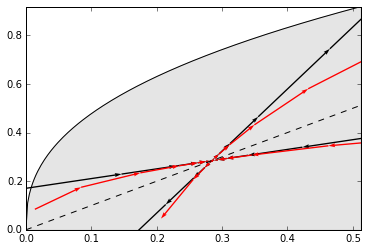

In [43]:
fig = plt.figure()
ax = fig.add_subplot(111)

kmax = 1.8 * ramsey.steady_state()[0]
k = np.linspace(0.0, kmax, 200)
ax.plot(k, ramsey.f(k), color='black')
ax.fill_between(k, ramsey.f(k), 0.0, color='black', alpha=0.1)
ax.plot(k, k, color='black', linestyle='dashed')

init_vals = find_initial_near_eqm(linearized, eps=1e-6)
for lambda_, inits in init_vals:
    if abs(lambda_) < 1:
        path = list(sim_linear.reset(inits, 15, inverse=True))
        path.reverse()
    else:
        path = list(sim_linear.reset(inits, 20, inverse=False))
    quiver_plot(ax, path, width=0.004, color='black')

for lambda_, inits in init_vals:
    if abs(lambda_) < 1:
        path = list(sim_ramsey.reset(inits, 16, inverse=True))
        path.reverse()
    else:
        path = list(sim_ramsey.reset(inits, 16, inverse=False))
    quiver_plot(ax, path, width=0.004, color='red')

ax.set_xlim([0, kmax])
ax.set_ylim([0, ramsey.f(k[-1])])
plt.show()

In [44]:
def plot_ramsey(A, α, ρ):
    ramsey = Ramsey(A, α, ρ)
    linearized = linearize(ramsey, ramsey.steady_state())

    sim_ramsey = Simulation(ramsey, domain=lambda x: ramsey.is_feasible(*x))
    sim_linear = Simulation(linearized)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    kmax = 1.8 * ramsey.steady_state()[0]
    k = np.linspace(0.0, kmax, 200)
    ax.plot(k, ramsey.f(k), color='black')
    ax.fill_between(k, ramsey.f(k), 0.0, color='black', alpha=0.1)
    ax.plot(k, k, color='black', linestyle='dashed')

    init_vals = find_initial_near_eqm(linearized, eps=1e-6)
    for lambda_, inits in init_vals:
        if abs(lambda_) < 1:
            path = list(sim_linear.reset(inits, 15, inverse=True))
            path.reverse()
        else:
            path = list(sim_linear.reset(inits, 20, inverse=False))
        quiver_plot(ax, path, width=0.004, color='black')

    for lambda_, inits in init_vals:
        if abs(lambda_) < 1:
            path = list(sim_ramsey.reset(inits, 16, inverse=True))
            path.reverse()
        else:
            path = list(sim_ramsey.reset(inits, 16, inverse=False))
        quiver_plot(ax, path, width=0.004, color='red')

    ax.set_xlim([0, kmax])
    ax.set_ylim([0, ramsey.f(k[-1])])
    plt.show()

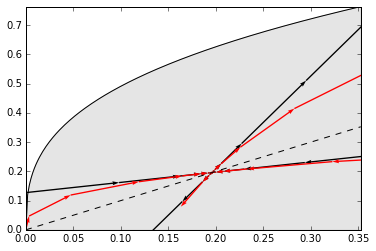

In [46]:
plot_ramsey(1.1, 0.35, 0.9)

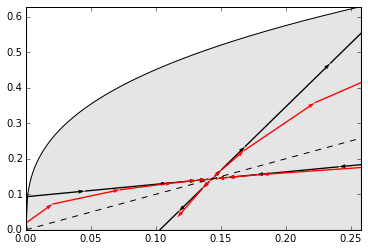

In [44]:
plot_ramsey(1.01, 0.35, 0.8)

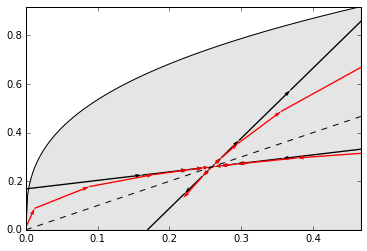

In [45]:
plot_ramsey(1.2, 0.35, 0.99)